In [ ]:
"""
File: waypoint.ipynb
Author: Clinton Reid
Description: performs segmentation on image sets in Images folder, performs exploratory analysis, return and saves important data and visualizations.
"""

In [ ]:
# # mounting folder for use with Google drive if necessary
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
# built-in imports
import os
from glob import glob

# libraries
import cv2 as cv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.spatial.distance as dist
from scipy import stats
from PIL import Image
from cellpose import plot, utils, models, io
from skimage.segmentation import find_boundaries
from skimage.io import imsave, imread
from skimage.measure import regionprops_table
from skimage.util import map_array
from skimage.morphology import erosion
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
# from statsmodels.stats.dist_dependence_measures import distance_correlation


In [4]:
current_folder = os.getcwd()
images_folder = os.path.join(current_folder, 'Images')

In [22]:
# images with the same 'rXXcXXfXXp01' represent an image set
# organizes image folder by creating folders for each image set, making further analysis simpler

images = os.listdir(images_folder)

for image in images:
    if image.endswith('.tiff'):
        image_set_id = image.split('p')[0] # using filenaming convention
        image_set_folder = os.path.join(images_folder, image_set_id)

        if not os.path.exists(image_set_folder):
            os.mkdir(image_set_folder)
        
        origin = os.path.join(images_folder, image)
        destination = os.path.join(image_set_folder, image)
        os.rename(origin, destination) # moving image files into their respective image set folder


In [5]:
def get_images_for_segmentation(images_folder, image_set_id):
    """
    Returns path to current image set folder, as well as a list of (path, image) tuples
    corresponding to each channel in the image set, to be used for segementation.

        Parameters:
            images_folder (str): path to the folder where all images are stored originally
            image_set_id (str): path to a particular image set represented by 'rXXcXXfXX'

        Returns:
            image_set_folder (str): path to the current image set folder
            all_channel_images (dict): dictionary with (key, value) pairs 
                                        (channel_id, (path_to_channel_image, channel_image))
                                        where channel_image (numpy array)
    """

    all_channel_images = {}
    image_set_folder = os.path.join(images_folder, image_set_id)
    
    for image in os.listdir(image_set_folder):
        if image.endswith('.tiff'): # looking only for images
            image_path = os.path.join(image_set_folder, image)
            channel_id = int(image.split('h')[1][0]) # based on naming convetion
            
            all_channel_images[channel_id] = (image_path, np.asarray(Image.open(image_path)))
            
    return image_set_folder, all_channel_images

def draw_segmentation_outlines_on_image(nuclear_masks, cell_masks, cell_image):
    """
    Returns membrane stain image with segmentation boundaries (both cellular and nuclear) drawn.

        Parameters:
            nuclear_masks (numpy array): output of segmentation on the nuclear channel image
            cell_masks (numpy array): output of segmentation on the membrane channel image
            cell_image (numpy array): membrane channel image

        Returns:
            drawn_image (Image object): image with segmentation boundaries drawn on membrane channel image
    """
    # skimage.segmentation to find the boundaries between masks // outlines as binary images
    nuclear_outlines = find_boundaries(nuclear_masks, mode='thick')
    cell_outlines = find_boundaries(cell_masks, mode='thick')

    image_rgb = plot.image_to_rgb(cell_image)

    # extract the pixel coordinates of nonzero (or white) pixels in the binary images representing outlines
    nuclear_outlines_Y, nuclear_outlines_X = np.nonzero(nuclear_outlines)
    cell_outlines_Y, cell_outlines_X = np.nonzero(cell_outlines)

    image_output = image_rgb.copy()

    # color the nuclear outlines red anf the cellular outlines green
    image_output[nuclear_outlines_Y, nuclear_outlines_X] = np.array([255, 0, 0])
    image_output[cell_outlines_Y, cell_outlines_X] = np.array([0, 255, 0])
    
    drawn_image = Image.fromarray(image_output, 'RGB')
    return drawn_image

In [10]:
## REGIONPROPSTABLE EXTRA PROPERTIES

def intensity_variance(mask, image):
    """
    Returns variance of intensities in an image in areas identified by mask.

        Parameters:
            mask (numpy array): image representing output of segmentation
            image (numpy array): image representing intensity image which was segemented

        Returns:
            variance of fluorescence intensity within masks
    """
    return np.var(image[mask])

def intensity_median(mask, image):
    return np.median(image[mask])

def intensity_percentiles(mask, image):
    return np.percentile(image[mask], q=(10, 25, 75, 90))

## PREPROCESSING

def add_prefix_df_cols_except(prefix, df, to_exclude):
    """
    Renames columns in DataFrame by adding desired prefix to columns names.

        Parameters:
            prefix (str): prefix to be prepended to column name
            df (pandas.DataFrame): some DataFrame with named columns
            to_exclude (list of str): columns (if any) to not prepend 

        Returns:
            df (pandas.DataFrame): Dataframe with renamed columns
    """
    df.columns = [prefix + '-' + col if col not in to_exclude else col for col in df.columns]
    return df

In [30]:
def match_image_properties_and_masks(nuclear_mask, cell_mask, nuclear_channel, membrane_channel, num_channels=5):

    """
    Returns dictionaries mapping channels by id to their masks and their desired properties to be extracted using 
    skimage.measure.regionprops_table

        Parameters:
            nuclear_mask (numpy array)
            cell_mask (numpy array)
            nuclear_channel (int): id of nuclear channel
            membrane_channel (int): id of membrane channel
            num_channels (int)L default 5 

        Returns:
            properties (dict): (key, value) = (channel_id, [propeties_for_regionprops_table])
            masks (dict) : (key, value) = (channel_id, mask_for_regionprops_table]
    """
    
    keys = range(1, num_channels + 1)
    properties = {key: ['label', 'intensity_mean'] for key in keys}
    masks = {key: cell_mask for key in keys} # all channels except nuclear will use cellular masks from membrane stain

    properties[nuclear_channel].extend(['centroid', 'area'])
    properties[membrane_channel].extend(['area', 'axis_major_length', 'axis_minor_length', 'perimeter'])

    masks[nuclear_channel] = nuclear_mask

    return properties, masks

def get_image_features(image_set_folder, all_channel_images, properties, masks, nuclear_channel, membrane_channel):
    """
    Returns the number of cells in a particular field of view, while also returning a DataFrame of desired cell 
    features for each cell in the field of view.

        Parameters:
            image_set_folder (str): path to the current image set folder, output of get_images_for_segmentation
            all_channel_images (dict): (key, value) = (channel_id, (path_to_channel_image, channel_image))
                                        channel_image (numpy array), output of get_images_for_segmentation
            properties (dict): properties (dict): (key, value) = (channel_id, [propeties_for_regionprops_table])
                                output of match_image_properties_and_masks
            masks (dict): (key, value) = (channel_id, mask_for_regionprops_table], output of match_image_properties_and_masks
            nuclear_channel (int): id of nuclear channel
            membrane_channel (int): id of membrane channel

        Returns:
            num_cells_fov (int): number of cells in the field of view
            merged_features_df (pandas.DataFrame) : table containing feature data for each cell in a field of view.
                Index:
                    RangeIndex
                Columns:
                    correspond to union of features in properties + extra_properties for their corresponding channels  
    """
    merged_features_df = pd.DataFrame()
    for channel_id in all_channel_images:
        # extract feature information and store as DataFrame
        feature_info = regionprops_table(masks[channel_id], all_channel_images[channel_id][1],
                                properties = properties[channel_id],
                                extra_properties = (intensity_variance, intensity_median, intensity_percentiles))
        feature_info_df = pd.DataFrame(feature_info)
        
        # saving nuclear center locations as csv
        if channel_id == nuclear_channel:
            feature_info_df[['centroid-0', 'centroid-1']].to_csv(os.path.join(image_set_folder, 'nuc_center.csv'))
            feature_info_df = add_prefix_df_cols_except('nuc', feature_info_df, ['label'])

        # naming membrane stain for analysis    
        elif channel_id == membrane_channel:
            feature_info_df = add_prefix_df_cols_except('cell', feature_info_df, ['label'])
        
        # identifying features by channel id
        else:
            feature_info_df = add_prefix_df_cols_except(str(channel_id), feature_info_df, ['label'])
    
        if merged_features_df.empty:
            merged_features_df = feature_info_df
        else:
            # merging channel features on label (1 cell = 1 label)
            merged_features_df = merged_features_df.merge(feature_info_df, on='label')
        
    num_cells_fov = len(feature_info_df) # no. of rows (labels) is number of cells
    return num_cells_fov, merged_features_df

In [31]:
## SEGMENTATION and saving results

# initialzing segmentation models 
nuc_model = models.Cellpose(gpu=False, model_type='nuclei')
cell_model = models.Cellpose(gpu=False, model_type='cyto')

# important channel id's
nuclear_channel = 5
membrane_channel = 2

num_cells_fov_df = pd.DataFrame(columns = ["fov", "no. of cells"])
image_sets = os.listdir(images_folder)

for image_set_id in image_sets:
    if '.' not in image_set_id:
        # going through each image set to perform segmentation
        image_set_folder, all_channel_images = get_images_for_segmentation(images_folder, image_set_id)
        
        # all_channel_images[i] = (path, image)
        nuc_path, nuc_image = all_channel_images[nuclear_channel][0], all_channel_images[nuclear_channel][1]
        cell_path, cell_image = all_channel_images[membrane_channel][0], all_channel_images[membrane_channel][1]

        nuc_mask, nuc_flows, nuc_styles, nuc_diams = nuc_model.eval(nuc_image, diameter=None)
        cell_mask, cell_flows, cell_styles, cell_diams = cell_model.eval(cell_image, diameter=None)
        
        # storing outputs of Cellpose model evaluation in .npy file
        io.masks_flows_to_seg([nuc_image, cell_image], [nuc_mask, cell_mask], [nuc_flows, cell_flows], [nuc_diams, cell_diams], [nuc_path, cell_path])
        
        # # saving masks as png
        # io.save_masks([nuc_image, cell_image], [nuc_mask, cell_mask], [nuc_flows, cell_flows], [nuc_path, cell_path])

        # generating and saving sesgmentation boundary overlays
        outline_image = draw_segmentation_outlines_on_image(nuc_mask, cell_mask, cell_image)
    
        plt.imshow(outline_image)
        plt.axis('off')
        plt.savefig(os.path.join(image_set_folder, 'outlines.png'), bbox_inches='tight', pad_inches=0)
        plt.close()
        
        properties, masks = match_image_properties_and_masks(nuc_mask, cell_mask, nuclear_channel, membrane_channel)

        # image features and cell count data
        num_cells_fov, combined_features_table = get_image_features(image_set_folder, all_channel_images, properties, masks, nuclear_channel, membrane_channel)
        num_cells_fov_df.loc[len(num_cells_fov_df.index)] = [image_set_id, num_cells_fov]
        combined_features_table.to_csv(os.path.join(image_set_folder, 'cells_and_features.csv'))
    
    num_cells_fov_df.to_csv(os.path.join(images_folder, 'number_of_cells_per_fov.csv'))

In [ ]:
# POST-PROCESSING (generating tables and masks)
combined_nucleus_locations = pd.DataFrame()
combined_cell_features = pd.DataFrame()

nuclei = []
features = []

for image_set_id in image_sets:
    if '.' not in image_set_id:
        image_set_folder = os.path.join(images_folder, image_set_id)
        
        # joining all cell data
        nucleus_location = pd.read_csv(os.path.join(image_set_folder, 'nuc_center.csv'))
        cell_features = pd.read_csv(os.path.join(image_set_folder, 'cells_and_features_1.csv'))
    
        num_cells = len(nucleus_location.index)

        well, fov = image_set_id.split('f')
        for i in range(num_cells):
            nucleus_location.loc[i, 'well'] = well
            nucleus_location.loc[i, 'fov'] = fov
            cell_features.loc[i, 'well'] = well
            cell_features.loc[i, 'fov'] = fov
        
        nuclei.append(nucleus_location)
        features.append(cell_features)

combined_nucleus_locations = pd.concat(nuclei, ignore_index=True)
combined_cell_features = pd.concat(features, ignore_index=True)

# final csv for all cells in all fovs nuclei and feature data
combined_nucleus_locations.to_csv(os.path.join(images_folder, 'all_cells_nuclei.csv'))
combined_cell_features.to_csv(os.path.join(images_folder, 'all_cell_features.csv'))

for name in ['all_cells_nuclei.csv', 'all_cell_features.csv']:
    df = combined_cell_data = pd.read_csv(os.path.join(images_folder, name))

    df = df.loc[:, [col for col in df.columns if not col.startswith('Unnamed:')]]

    front_columns = ['well', 'fov']

    new_order = front_columns + [col for col in df if col not in front_columns]
    df = df[new_order]

    df.to_csv(os.path.join(images_folder, name))


In [ ]:
def contrast_stretch(image):
    """
    Returns an image with intensity values transformed to a new range, increasing contrast.

        Parameters:
            image (numpy array): 8-bit image

        Returns:
            stretched (numpy array): high-contrast 8-bit image
    """
    min_range, max_range = 0, 255

    min_intensity = np.min(image)
    max_intensity = np.max(image)

    stretched = np.uint8((image - min_intensity) / (max_intensity - min_intensity) * (max_range - min_range) + min_range)

    return stretched

In [ ]:
for image_set_id in image_sets:
    if '.' not in image_set_id:
        image_set_folder = os.path.join(images_folder, image_set_id)
        dats = glob(image_set_folder + '/*_seg.npy')

        # extracting masks from npy file
        for dat in dats:
            base = dat[:-8]
            out = base + '_cp_masks.png'

            npy = np.load(dat, allow_pickle=True)
            masks = npy[()]['masks'].astype('uint8')

            imsave(out, masks)
            # print('saving now')

        # turning these masks into high-contrast images
        masks = glob(image_set_folder + '/*_masks.png')
        
        for mask in masks:
            name, ext = mask.split('.')

            mask_img = cv.imread(mask, cv.IMREAD_GRAYSCALE)

            mask_img = contrast_stretch(mask_img)

            cv.imwrite(name + '_hc.' + ext, mask_img)
        # print('boosting contrast...')


In [ ]:
## VISUALIZATION AND ANALYSIS
""" 
- boxplots showing distributions of intensity means for each channel in each well
- correlation heatmaps highlighting relationships between intensities of each channel in each well
- PCA, scatterplots representing correlations between principal components and intensity means
    - plots of distributions of intensity means for each channel
- distributions (histogram) of cell major axis length, aspect ratios
- scatterplots showing relationship between major axis and minor axis length color coded by well
- violin plots showing distribution of aspect ratios by well
"""

In [26]:
df = combined_cell_features = pd.read_csv(os.path.join(images_folder, 'all_cell_features.csv'))

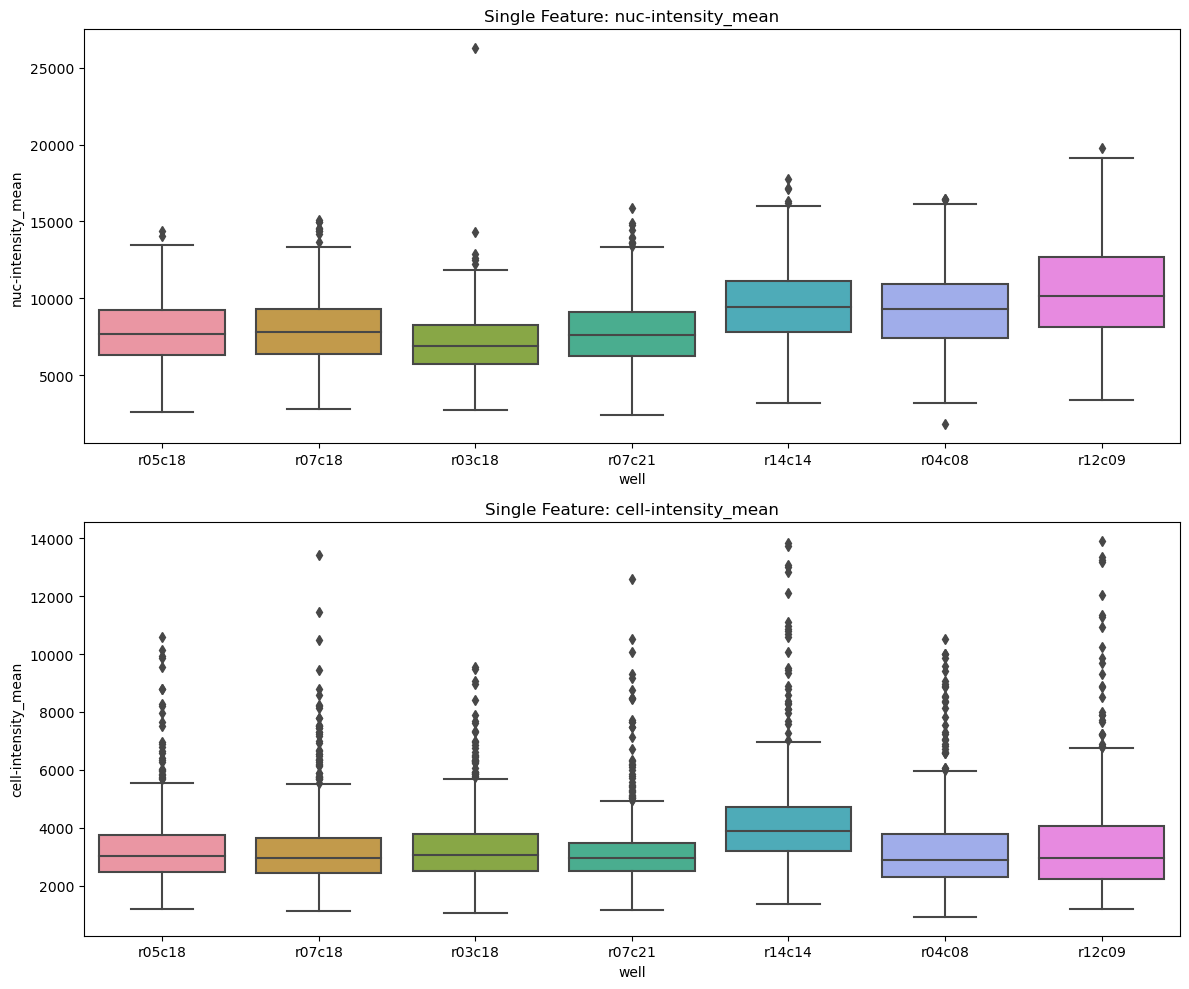

In [27]:
features = ['nuc-intensity_mean', 'cell-intensity_mean']

sns.set_palette("husl")

fig, axes = plt.subplots(nrows=len(features), ncols=1, figsize=(12, 10))

# iterate through features and plot
for i, feature in enumerate(features):
    sns.boxplot(x='well', y=feature, data=df, ax=axes[i])
    axes[i].set_title(f'Single Feature: {feature}')

plt.tight_layout()
plt.savefig("important_intensity_boxplot.png")
plt.show()

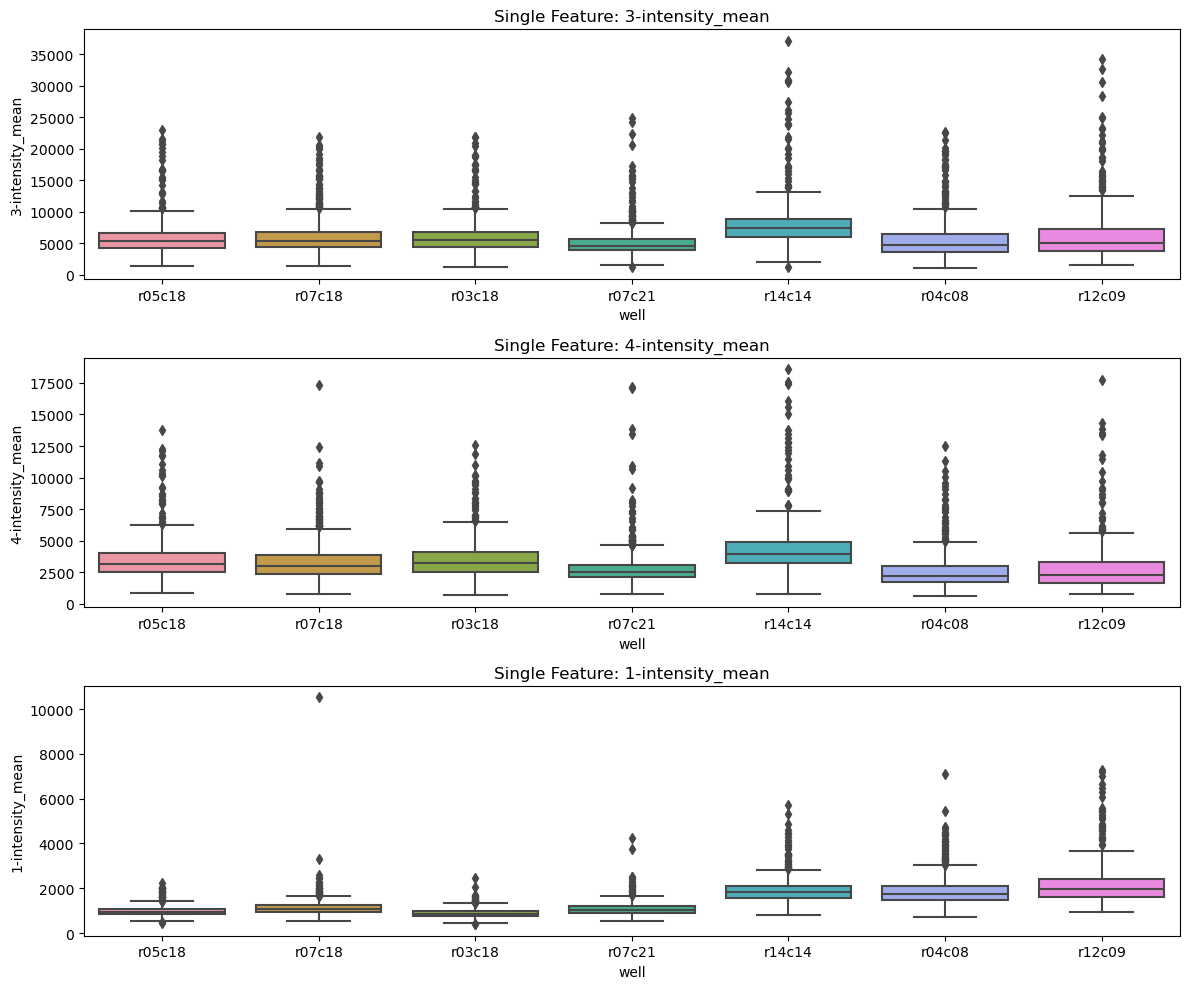

In [28]:
features = ['3-intensity_mean', '4-intensity_mean', '1-intensity_mean']
sns.set_palette("husl")

fig, axes = plt.subplots(nrows=len(features), ncols=1, figsize=(12, 10))

# Iterate through features and plot
for i, feature in enumerate(features):
    sns.boxplot(x='well', y=feature, data=df, ax=axes[i])
    axes[i].set_title(f'Single Feature: {feature}')

plt.tight_layout()
plt.savefig("other_channels_intensity_boxplot.png")
plt.show()

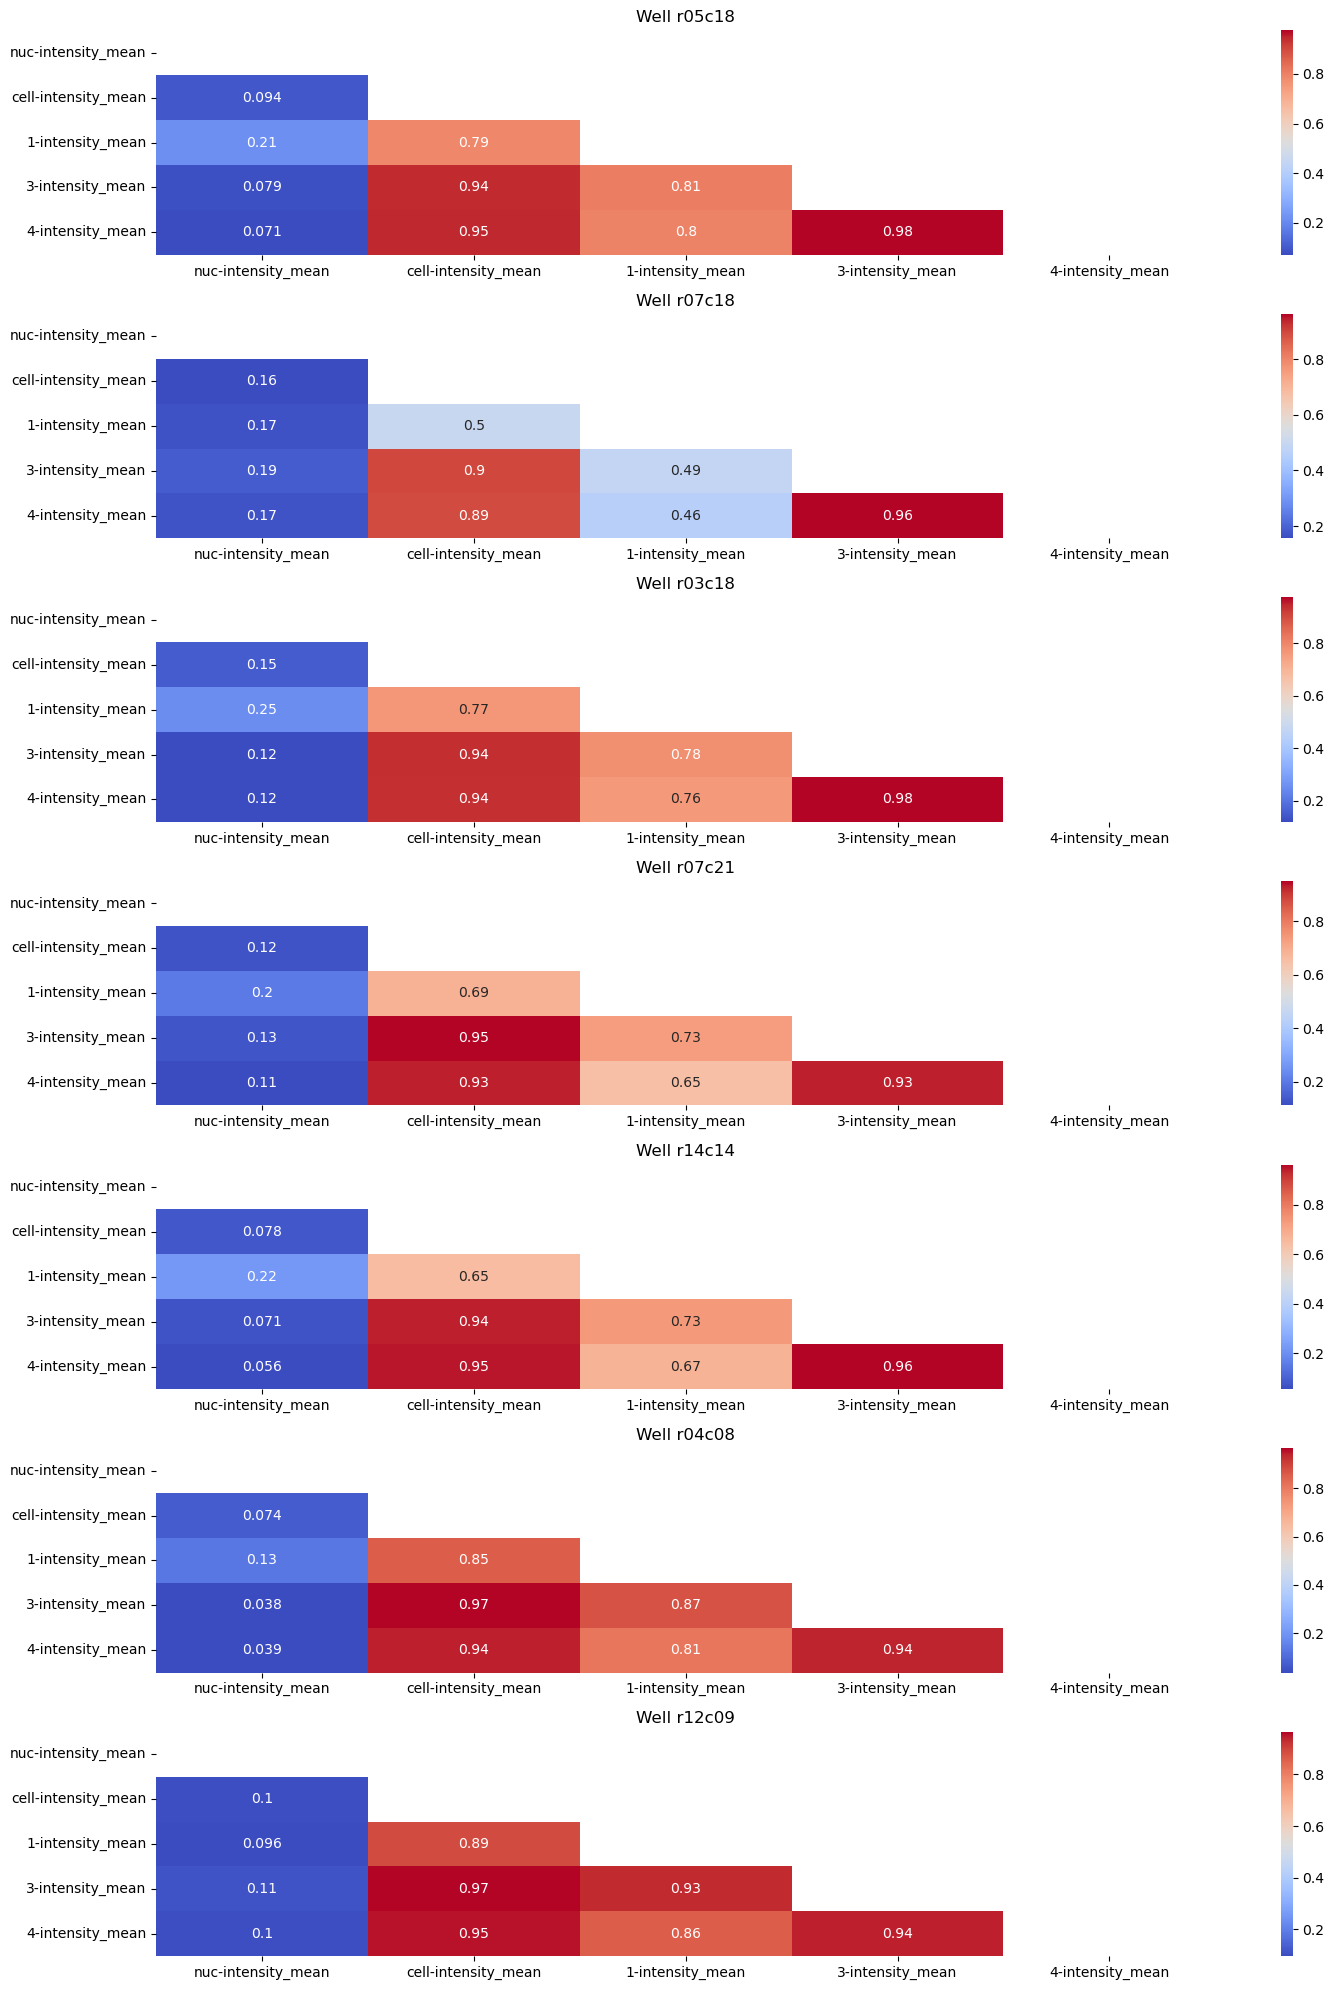

In [29]:
corr_features = ['nuc-intensity_mean', 'cell-intensity_mean', '1-intensity_mean', '3-intensity_mean', '4-intensity_mean']

df = correlation_df = df[corr_features + ['well']]
unique_wells = df['well'].unique()

n_subplots = len(unique_wells)

fig, axes = plt.subplots(n_subplots, 1, figsize=(15, 20))

# Loop through each well and create a correlation heatmap between intensity means
for i, well in enumerate(unique_wells):
    well_data = df[df['well'] == well].copy()
    
    well_data.drop('well', axis=1, inplace=True) # drop well column for correlation calc 
    corr_matrix = well_data.corr()
    
    # make the heatmap lower triangular (stylistic)
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    ax = axes[i]

    sns.heatmap(corr_matrix, annot=True, mask=mask, cmap='coolwarm', ax=ax)
    ax.set_title(f'Well {well}')
    
plt.tight_layout()
plt.savefig("intensity_corr_by_well.png")
plt.show()

In [ ]:
# Extract well and intensity mean columns
intensity_columns = ['nuc-intensity_mean', 'cell-intensity_mean', '1-intensity_mean', '3-intensity_mean', '4-intensity_mean']

df = combined_cell_features = pd.read_csv(os.path.join(images_folder, 'all_cell_features.csv'))

well_data = df["well"]
intensity_data = df[intensity_columns]
intensity_data = intensity_data.fillna(intensity_data.median())

# z-scoring to standaradize data across scales
scaler = StandardScaler()
intensity_data_zscore = scaler.fit_transform(intensity_data)

# PCA 
pca = PCA(n_components=2)
pca_data = pca.fit_transform(intensity_data_zscore)

# pairwise correlation between principal components and columns of interest
corr_with_pc1 = [np.corrcoef(pca_data[:, 0], intensity_data[col])[0, 1] for col in intensity_columns]
corr_with_pc2 = [np.corrcoef(pca_data[:, 1], intensity_data[col])[0, 1] for col in intensity_columns]

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))

# principal components scatter
sns.scatterplot(x=pca_data[:, 0], y=pca_data[:, 1], hue=well_data, ax=axes[0, 0])
axes[0, 0].set_title("PC1 vs PC2 (Color-coded by Well)")

# pc1 and pc2 correlations bar
sns.barplot(x=corr_with_pc1, y=intensity_columns, ax=axes[0, 1])
axes[0, 1].set_title("Correlation with PC1")
sns.barplot(x=corr_with_pc2, y=intensity_columns, ax=axes[1, 0])
axes[1, 0].set_title("Correlation with PC2")

explained_variance_ratio = pca.explained_variance_ratio_
axes[1, 1].bar(range(1, 3), explained_variance_ratio, tick_label=["PC1", "PC2"])
axes[1, 1].set_title("Explained Variance Ratio")

plt.tight_layout()
plt.savefig("pca_intensity_scatter_and_bars.png")
plt.show()

In [ ]:
df["principal_component_1"] = pca_data[:, 0]
df["principal_component_2"] = pca_data[:, 1]

# pair grid of scatter plots for both PC1 and PC2 vs. all columns
g = sns.PairGrid(df, vars=intensity_columns + ["principal_component_1", "principal_component_2"], hue="well", palette="Set1", diag_sharey=False)
g = g.map_upper(plt.scatter)
g = g.map_lower(plt.scatter)
g = g.map_diag(sns.kdeplot, lw=2, legend=False)

g.add_legend()

plt.savefig("pairgrid_pcs_intensity_plot.png")
plt.show()

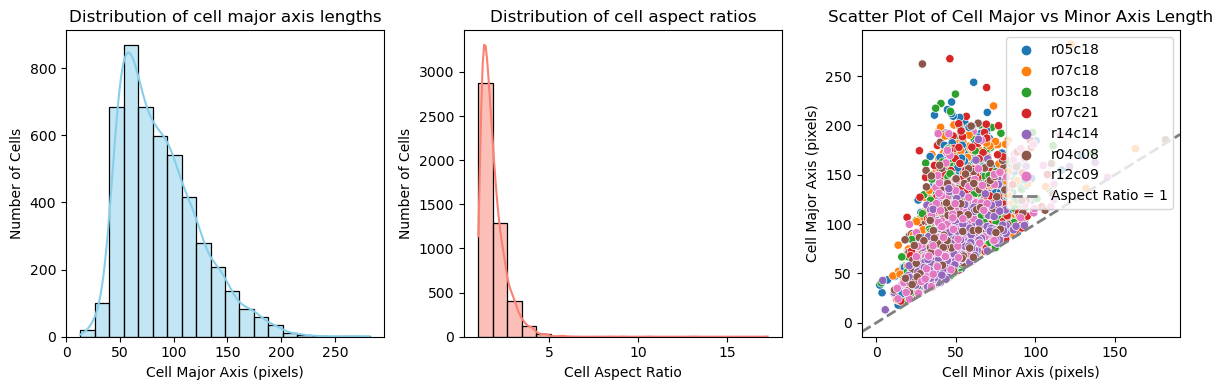

In [24]:
size_columns = ['well','nuc-area', 'cell-area', 'cell-axis_major_length', 'cell-axis_minor_length', 'cell-perimeter']

df = combined_cell_features = pd.read_csv(os.path.join(images_folder, 'all_cell_features.csv'))

df = size_data = df[size_columns]

# distribution of cell major axis lengths
plt.figure(figsize=(12, 4))
plt.subplot(131)
sns.histplot(df, x='cell-axis_major_length', bins=20, kde=True, color='skyblue')
plt.title('Distribution of cell major axis lengths')
plt.xlabel('Cell Major Axis (pixels)')
plt.ylabel('Number of Cells')

# histogram showing distribution of aspect ratios
aspect_ratios = df['cell-axis_major_length'] / df['cell-axis_minor_length']
plt.subplot(132)
sns.histplot(aspect_ratios, bins=20, kde=True, color='salmon', edgecolor='black')
plt.title('Distribution of cell aspect ratios')
plt.xlabel('Cell Aspect Ratio')
plt.ylabel('Number of Cells')

# scatter plot major minor axes
plt.subplot(133)
sns.scatterplot(data=df, x='cell-axis_minor_length', y='cell-axis_major_length', hue='well', palette='tab10')
plt.title('Scatter Plot of Cell Major vs Minor Axis Length')
plt.xlabel('Cell Minor Axis (pixels)')
plt.ylabel('Cell Major Axis (pixels)')
plt.axline((0, 0), slope=1, color='gray', linestyle='--', linewidth=2, label='Aspect Ratio = 1')
plt.legend(loc='best')

plt.tight_layout()
plt.savefig("major_minor_axis_plots.png")
plt.show()

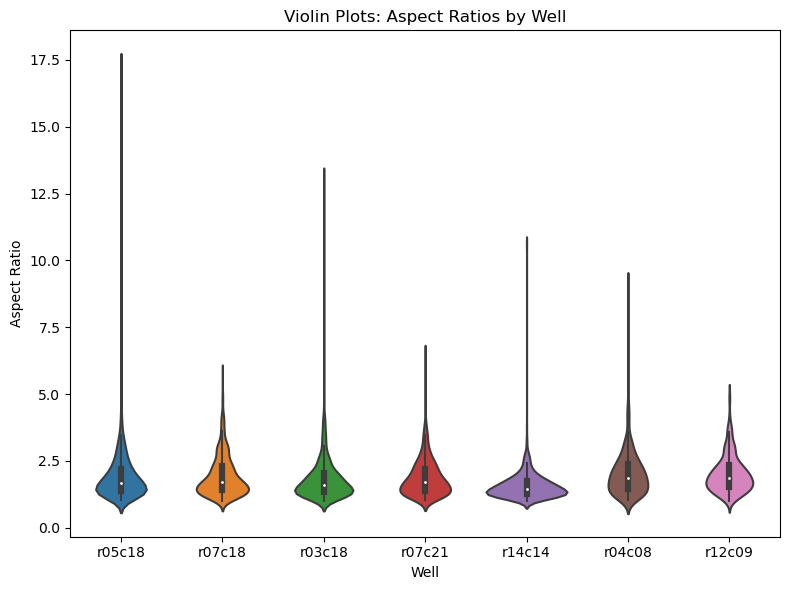

In [23]:
asp = df['cell-axis_major_length'] / df['cell-axis_minor_length']
# distribution of aspect ratios color coded by well
plt.figure(figsize=(8, 6))
sns.violinplot(data=df, x='well', y=asp, palette='tab10')
plt.title('Violin Plots: Aspect Ratios by Well')
plt.xlabel('Well')
plt.ylabel('Aspect Ratio')

plt.tight_layout()
plt.savefig("aspect_ratio_violin_plot.png")
plt.show()